# cawa19_ARIMA-one step forecast

In [26]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#from sklearn.cross_validation import cross_val_score
#from sklearn.cross_validation import cross_val_predict
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from alex.database import Database
from pprint import pprint
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

### Загрузка  данных

In [3]:
# результат выполнения запроса:
# select * from tvf_get_order_book_snapshots(2880) where exchange='binance' and pair='ETH/USDT' # запрос на 20 минут
#order = pd.read_csv('tvf_get_order_book_snapshots 15.09.2018-01.10.2018.zip', index_col='dt')

In [4]:
# загрузка истории
# 15 секунд
db = Database()
sql_history = f"select * from v_history where exchange='binance' and pair='ETH/USDT' and dt>'2018-08-1'"
df_history = db.query(sql_history)
df_history.set_index('dt', inplace=True)

In [5]:
df_history.shape

(4621586, 11)

In [7]:
#перевод в нужные интервалы
interval = 60 # minutes

#df = history[['price', 'amount']].resample(str(interval)+'min').ohlc()
hist = df_history[['price', 'amount']].resample(str(interval)+'min').mean()
hist.shape

(2006, 2)

In [8]:
hist.fillna(method='ffill', inplace=True)

In [9]:
hist.head()

,price,amount
dt,,
2018-08-07 03:00:00,406.501000,1.378627
2018-08-07 04:00:00,405.592896,7.824664
2018-08-07 05:00:00,405.592896,7.824664
2018-08-07 06:00:00,405.592896,7.824664
2018-08-07 07:00:00,405.592896,7.824664


In [10]:
plt.rcParams['figure.figsize'] = [14, 7]

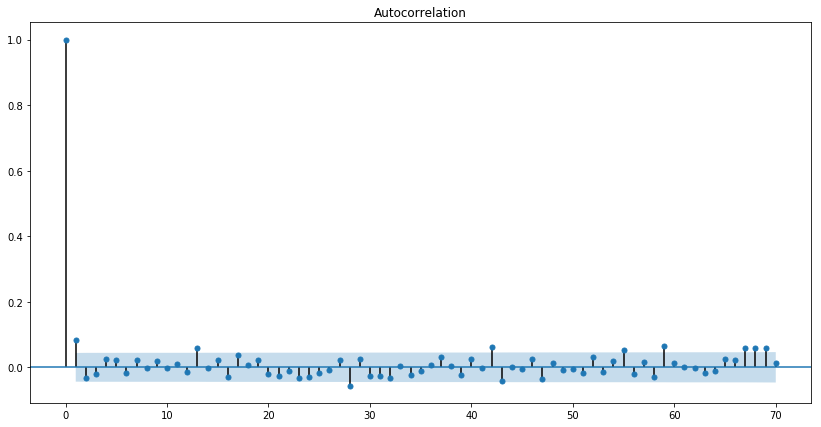

In [11]:
_ = plot_acf(hist[0:len(hist)].price.diff().dropna(), lags=70, alpha=0.05)

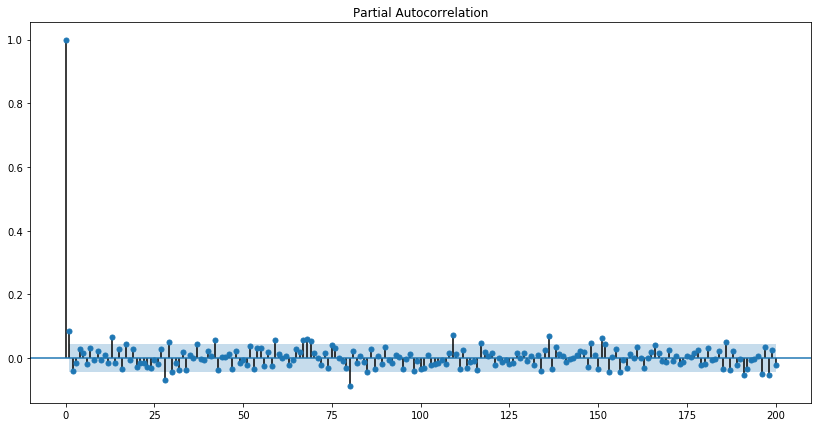

In [12]:
_ = plot_pacf(hist[0:len(hist)].price.diff().dropna(), lags=200, alpha=0.05)

In [13]:
#test-train split

split_point = int(len(hist)*.75)
train, test = hist[0:split_point], hist[split_point:len(hist)]
len(hist), len(train), len(test)

(2006, 1504, 502)

In [14]:
model = ARIMA(train.price, order=(1,1,0))

In [15]:
model_fit = model.fit()

In [16]:
plt.rcParams['figure.figsize'] = [16, 9]

<Figure size 1152x648 with 0 Axes>

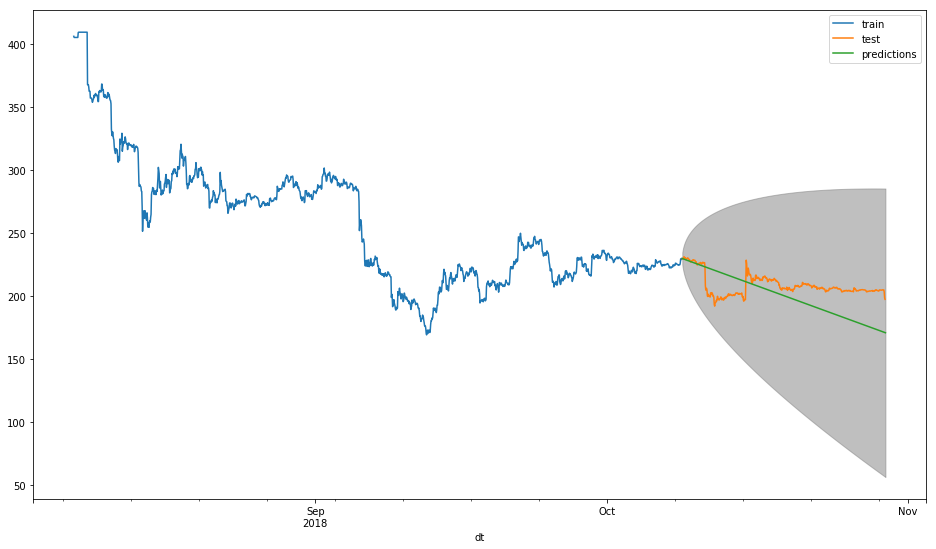

In [17]:
plt.figure()
fig, ax = plt.subplots()

train.price.plot()
test.price.plot(ax=ax)
model_fit.plot_predict(start=len(train), end=len(hist), alpha=0.1, ax=ax)

ax.legend(['train', 'test', 'predictions'])
plt.show()

In [18]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 1503
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3736.836
Method:                       css-mle   S.D. of innovations              2.908
Date:                Mon, 29 Oct 2018   AIC                           7479.672
Time:                        16:03:10   BIC                           7495.618
Sample:                    08-07-2018   HQIC                          7485.612
                         - 10-08-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1174      0.080     -1.466      0.143      -0.274       0.040
ar.L1.D.price     0.0635      0.026      2.469      0.014       0.013       0.114
                                    Root

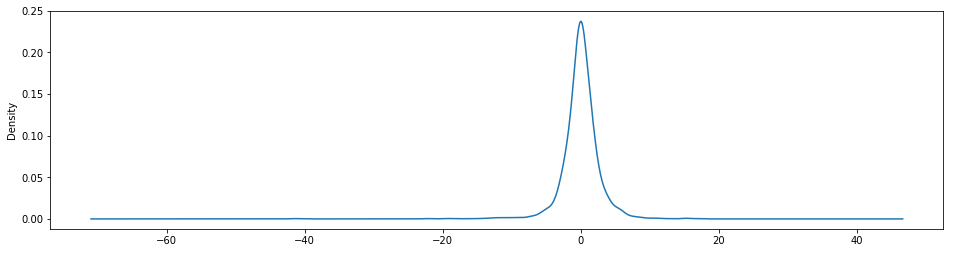

In [20]:
model_fit.resid.plot(kind='kde', figsize=(16,4))

In [21]:
model_fit.resid.describe()

count    1503.000000
mean        0.000033
std         2.908521
min       -41.557291
25%        -0.961706
50%         0.084830
75%         1.156673
max        17.234266
dtype: float64

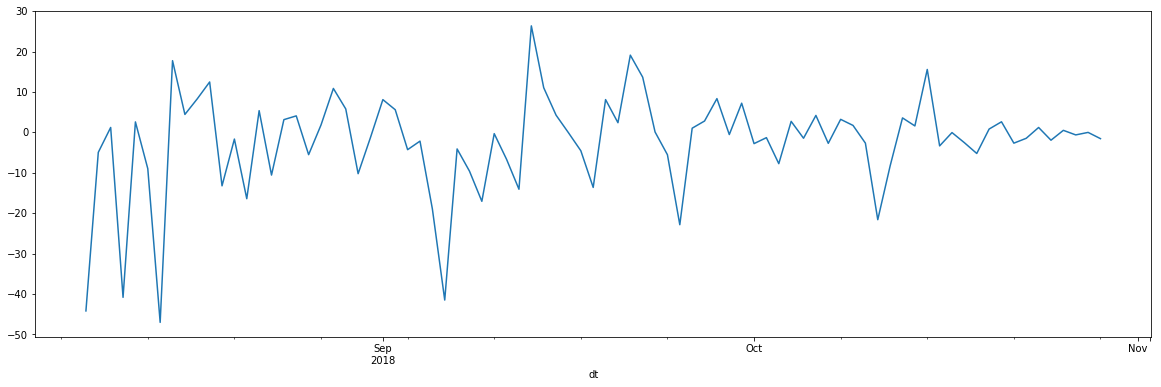

In [27]:
df_history.resample('D').price.mean().diff().plot(figsize=(20,6))

In [79]:
train.tail()

,price,amount
dt,,
2018-10-08 14:00:00,226.511006,3.246902
2018-10-08 15:00:00,229.735862,3.585633
2018-10-08 16:00:00,229.237502,2.608416
2018-10-08 17:00:00,229.439284,2.826862
2018-10-08 18:00:00,230.100346,3.093431


In [77]:
frcst = pd.DataFrame(model_fit.forecast(steps=504)[0])
frcst.head()

,0
0,230.032445
1,229.918222
2,229.801056
3,229.683702
4,229.566337


In [61]:
start = len(train.loc[:'2018-10-07 21:00:00'])
end = len(train) + 1
start, end

(1483, 1505)

In [85]:
model_fit.predict(start=1500, end=1506) + train.price[-1]

2018-10-08 15:00:00    230.076095
2018-10-08 16:00:00    230.195361
2018-10-08 17:00:00    229.958770
2018-10-08 18:00:00    230.003260
2018-10-08 19:00:00    230.032445
2018-10-08 20:00:00    229.986124
2018-10-08 21:00:00    229.983180
Freq: 60T, dtype: float64

In [86]:
train.tail()

,price,amount
dt,,
2018-10-08 14:00:00,226.511006,3.246902
2018-10-08 15:00:00,229.735862,3.585633
2018-10-08 16:00:00,229.237502,2.608416
2018-10-08 17:00:00,229.439284,2.826862
2018-10-08 18:00:00,230.100346,3.093431
